In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

train=pd.read_csv("CAX_LogFacies_Train_File.csv" )
#test=pd.read_csv("CAX_LogFacies_Test_File.csv")

In [34]:
train=pd.read_csv("CAX_LogFacies_Train_File.csv" )

pivoted = pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR")
pivoted.columns = ["label0","label1","label2","label3","label4"]
n = 1100
a = 0.11
b = 0.45
trainsample = pivoted.query(f"label0<{b}*{n} and label1>{a}*{n} and label2>{a}*{n} and label3>{a}*{n} and label4>{a}*{n}").index
train = train[train["well_id"].isin(trainsample)]
names  = ["Serrated","Symmetrical", "Cylindrical" ,  "Funnel" ,    "Bell"]
for n,i in enumerate(names):
    train.loc[train["label"] ==n,"name"] = i

In [35]:
len(set(train["well_id"]))

52

## Gráfico ejemplo de lo que se encuentra en un pozo del dataset. Se ve que la clase 0 (azul) es la clase mayoritaria que presenta menor tendencia que las otras
## En negro sobre el eje derecho se ve el numero de label de cada clase

## Distribucion total de las clases

Text(0.5, 0, 'Wells')

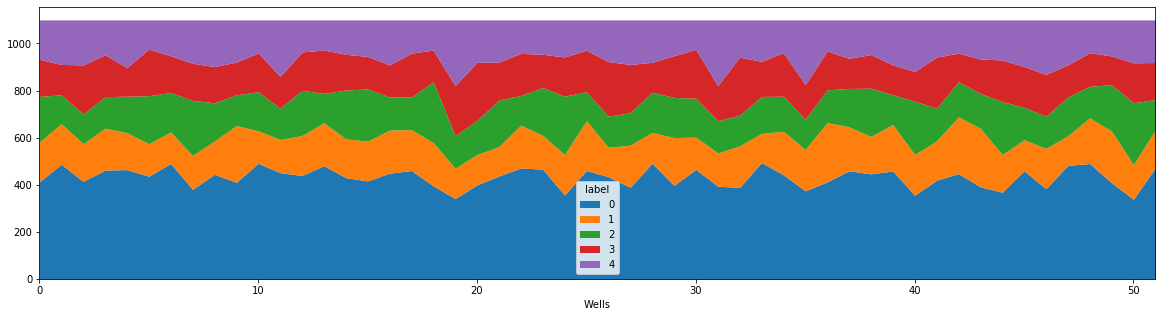

In [36]:
pivoted = pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR")

pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR").reset_index(drop =True).plot(kind = 'area',figsize=(20,5),linewidth = 0.01,)
plt.xlabel("Wells")
plt.xlabel("Wells")


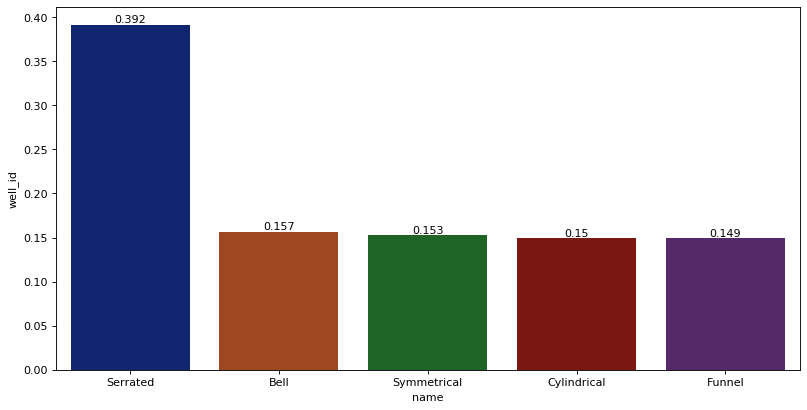

<Figure size 1080x720 with 0 Axes>

In [37]:
# sns.set_style("whitegrid")

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

data = (train.groupby(['name']).count()/train.count())[["well_id"]]
data.sort_values("well_id", ascending = False, inplace= True)
graph = sns.barplot(x=data.index,y='well_id', data=data, palette='dark',label="name")

plt.figure(figsize=(15,10))
for p in graph.patches:
        graph.annotate(f'{p.get_height().round(3)}', (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')


## Distribucion cada clase a lo largo de la profundidad del pozo
## Vemos que en los extremos hay principalmente labels 0

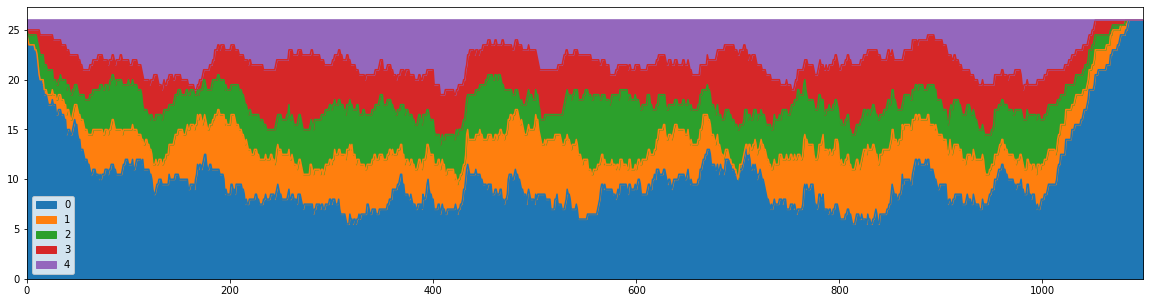

In [38]:
pivoted = pd.pivot_table(data = train,columns  = "well_id",aggfunc='mean' ,index = 'row_id',values = "label")
df=pd.DataFrame()
for i in range(5):
    df=df.append(pivoted[pivoted == i].count(axis=1),ignore_index =True)
df = df.transpose()
(df/2).plot(kind="area",figsize=(20,5))

In [39]:
len(train["well_id"].unique())

52

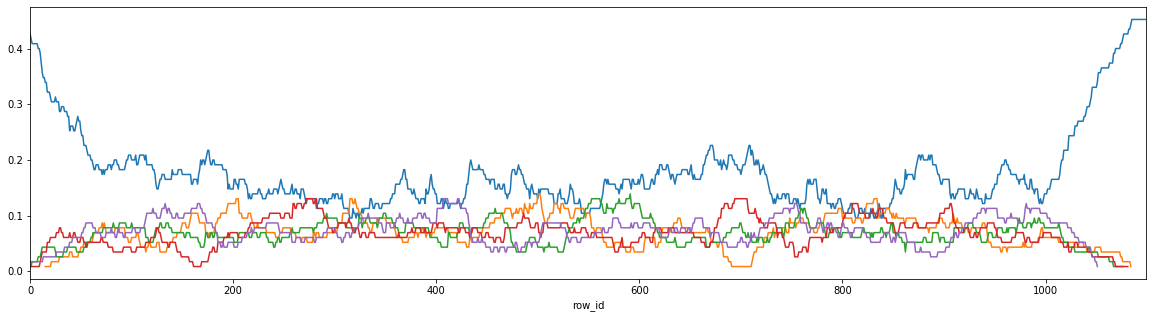

In [40]:
pivoted = pd.pivot_table(data = train.query("label == 0"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = train.query("label == 1"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = train.query("label == 2"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = train.query("label == 3"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = train.query("label == 4"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot()

## Distribucion de clases por pozo. Vemos que la clase mayoritaria es un 50% en casi todos los pozos y la distribucion de las demas es casi la misma

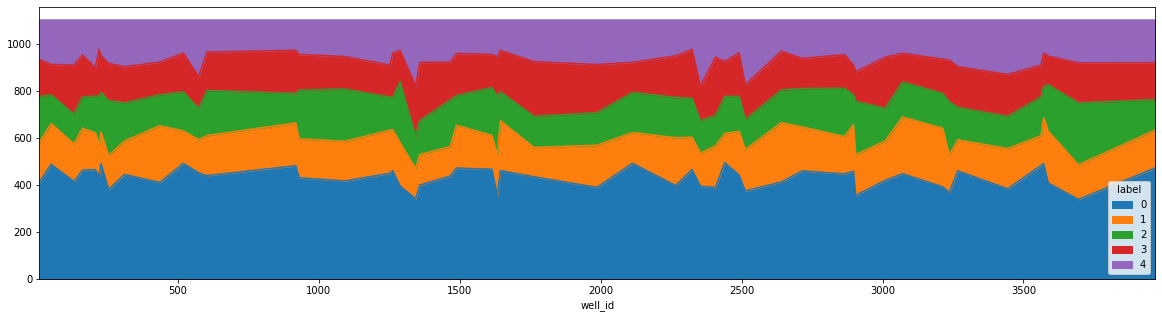

In [41]:
pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR").plot(kind = "area", figsize = (20,5))

## Feature Engineering
## Se propuso Normalizar y Standarizar la unica feature GR
## Se calculo tambien 3 ventanas de medias utilizando GR normalizados y el GR Standarizado tomando ventanas de 5, 10 y 15. Tambien se calculo la ventana de variacion de 10 de rango. 

In [43]:
def huberlambda(x,y):
    X = np.array(range(x)).reshape(-1,1)
    huber = HuberRegressor().fit(X, y)
    return huber



train['GR_mnorm'] = train.groupby('well_id')['GR'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
train["1huber"] = train.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: huberlambda(20, y).coef_,'raw=False').reset_index(0,drop=True)
train["2huber"] = train.groupby('well_id')['GR_mnorm'].rolling(40,center=True).apply(lambda y: huberlambda(40, y).coef_,'raw=False').reset_index(0,drop=True)


# train["0polyfit"] = train.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: np.polyfit(np.array(range(20)), y, 2)[0],'raw=False').reset_index(0,drop=True)
train["1polyfit"] = train.groupby('well_id')['GR_mnorm'].rolling(30,center=True).apply(lambda y: np.polyfit(np.array(range(30)), y, 2)[1],'raw=False').reset_index(0,drop=True)
# train["2polyfit"] = train.groupby('well_id')['GR_mnorm'].rolling(50,center=True).apply(lambda y: np.polyfit(np.array(range(50)), y, 2)[2],'raw=False').reset_index(0,drop=True)

# train['20rolling_mean'] = train.groupby('well_id')['GR_mnorm'].rolling(20,win_type = "barthann",min_periods=1,center= True).mean().reset_index(0,drop=True)
train['30rolling_mean'] = train.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)
# train['40rolling_mean'] = train.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)



train['20rolling_std'] = train.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
# train['40rolling_std'] = train.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
train=train.fillna(0)

## Se grafico el pozo 22 junto con el suavizado de medias de ventana 5 y la ventana de variacion

In [44]:
def transform_shfit(df,k,GR):
    for i in range(1,k):
        a = i*2
        df["- "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(a))
        df["+ "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(-a))
    df=df.fillna(0)
    return df

train=transform_shfit(train,10,"30rolling_mean")
train=transform_shfit(train,10,"1huber")
train=transform_shfit(train,10,"GR_mnorm")
train=train.fillna(0)


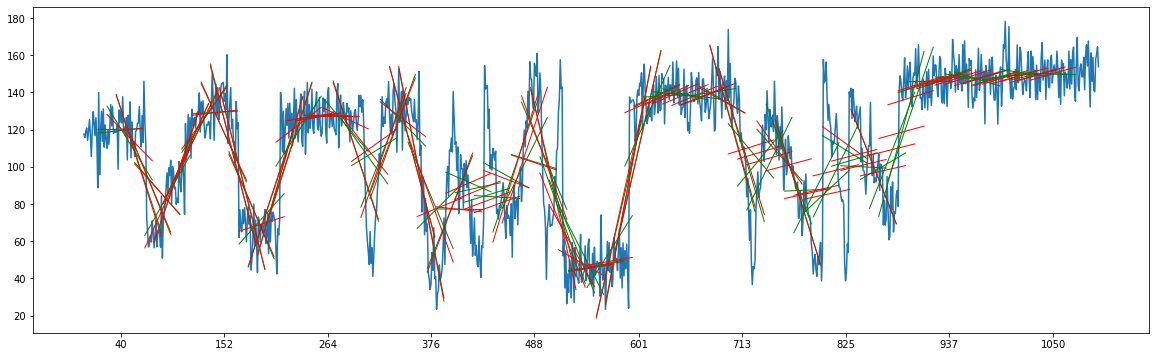

In [6]:
def huberlambda(x,y):
    x = x.values.reshape(-1,1)
    interval = range(y)
    huber = HuberRegressor().fit(x, interval)
    return huber
test = train.iloc[:1100].reset_index()
fig = plt.figure(figsize=(20, 6))
plt.plot(test["GR"])

for i in np.linspace(40,1050,100, dtype=int):
    distance = 50
    ubic = i
   
    x = test.iloc[int(ubic-distance/2):int(ubic+distance/2)].index.values.reshape(-1,1)
    y = test.iloc[int(ubic-distance/2):int(ubic+distance/2)]["GR"]
    lr = LinearRegression()
    lr.fit(x,y.values.reshape(-1,1))
    lcoef_ = lr.coef_ *x + lr.intercept_
    plt.plot( x ,lcoef_, color = "g",linewidth="1")
    
    hb = HuberRegressor(epsilon = 1.5)
    hb.fit(x,y)
    hbcoef_ = hb.coef_ *x + hb.intercept_
    plt.plot( x, hbcoef_,color = "r",linewidth="1")
plt.xticks(np.linspace(40,1050,10, dtype=int));
# plt.plot(range(200,300),range(200,300), color = "g")


In [ ]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i)).reset_index()
    labels= df["label"].unique()
    print(labels)
    palette1 = sns.color_palette('pastel', len(labels))
    palette2 = sns.color_palette('deep', len(labels))

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copy = df.copy()
        copy.loc[copy['label']!= l,[ "GR","3huber" ]] = np.nan
        axes1.plot(copy["GR"], color=palette2[l])
        axes2.plot(copy["3huber"], color="b") 
#         axes2.plot(copy["2huber"], color="r") 
#         axes2.plot(copy["3huber"], color="k") 
plot_multicolored_line(train ,1)


In [ ]:
def plot_multicolored_line(df, i):
    df = train.query("well_id  in '{}'".format(i)).reset_index()
    labels= df["label"].unique()
    palette1 = sns.color_palette('dark', 5)
    palette2 = sns.color_palette('pastel', 5)
    plt.figure(figsize=(20, 6))
    for l in list(labels):
        copy = df.copy()
        copy.loc[copy['label']!= l,[ "GR_mnorm","huber","2huber","3huber" ]] = np.nan
        plt.plot(copy["GR"], color=palette2[l])
#         plt.plot(copy["huber"], color="b") 
#         plt.plot(copy["2huber"], color="r") 
        plt.plot(copy["3huber"], color="k") 

plot_multicolored_line(train ,3969)


## Se agrego el valor de los siguientes 10 valores para atras y para adelante de cada punto para las ventanas de medias y ventana de variacion

## Division 40 pozos enteros para train y 10 pozos para test.

In [45]:
train.drop("name",axis=1,inplace=True,errors ="ignore")
y=train["label"]
x=train.drop("label",axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle = False )

In [51]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, x_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(100,200)),
    'max_features': hp.choice('max_features', np.arange(0.3,1,0.1)),
    'n_estimators': hp.choice('n_estimators', range(100,400)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=20, trials=trials)

print ('best:')
print (best)

new best:                                                                                                              
0.8731018981018982                                                                                                     
{'criterion': 'entropy', 'max_depth': 104, 'max_features': 0.4, 'n_estimators': 153}                                   
new best:                                                                                                              
0.8731018981018982                                                                                                     
{'criterion': 'gini', 'max_depth': 141, 'max_features': 0.6000000000000001, 'n_estimators': 238}                       
 10%|████▍                                       | 2/20 [54:44<8:12:40, 1642.26s/trial, best loss: -0.8731018981018982]


KeyboardInterrupt: 

In [21]:
bayes_trials_results  = sorted(trials.results, key = lambda x: x['loss'])
bayes_trials_results [:2]

[{'loss': -0.8785996612083569, 'status': 'ok'},
 {'loss': -0.8781931112365895, 'status': 'ok'}]

In [46]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=150, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Score evaluado sobre el mismo training 0.990341

In [48]:
predictions = model.predict(x_test)
model.score(x_train, y_train)

0.9939060939060939

In [11]:

test = x_test.copy()
test["predictions"] = predictions
test.loc[test["predictions"]== 1, "predictions"] = 2
test["label"] = y_test
test.loc[test["predictions"]>0,"predictionsuni"] = 2
test.loc[test["label"]>0,"labeluni"] = 1

In [ ]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i))
    labels= df["label"].unique()
    palette1 = sns.color_palette('pastel', len(labels))
    palette2 = sns.color_palette('dark', len(labels))

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copydf = df.copy()
        copydf.loc[copydf['label']!= l, ["GR","labeluni","predictionsuni"]] = np.nan
        axes1.plot(copydf["GR"], color=palette1[l])
        axes2.plot(copydf["predictionsuni"], color=palette1[l])
        axes2.plot(copydf["labeluni"], color=palette2[l])
plot_multicolored_line(test ,3000)


In [49]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
model.score(x_test, y_test)

[[6354   34    0   97   84]
 [ 212 1994  264  233  129]
 [   0  125 2305  137   73]
 [ 205  212   46 1931   36]
 [ 378  130   69   37 2075]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6569
           1       0.80      0.70      0.75      2832
           2       0.86      0.87      0.87      2640
           3       0.79      0.79      0.79      2430
           4       0.87      0.77      0.82      2689

    accuracy                           0.85     17160
   macro avg       0.84      0.82      0.83     17160
weighted avg       0.85      0.85      0.85     17160



0.8542540792540793

## Score evaluado sobre los 10 pozos de testing. 0.87

## Importancia de las variables junto con su variacion en el random forest:

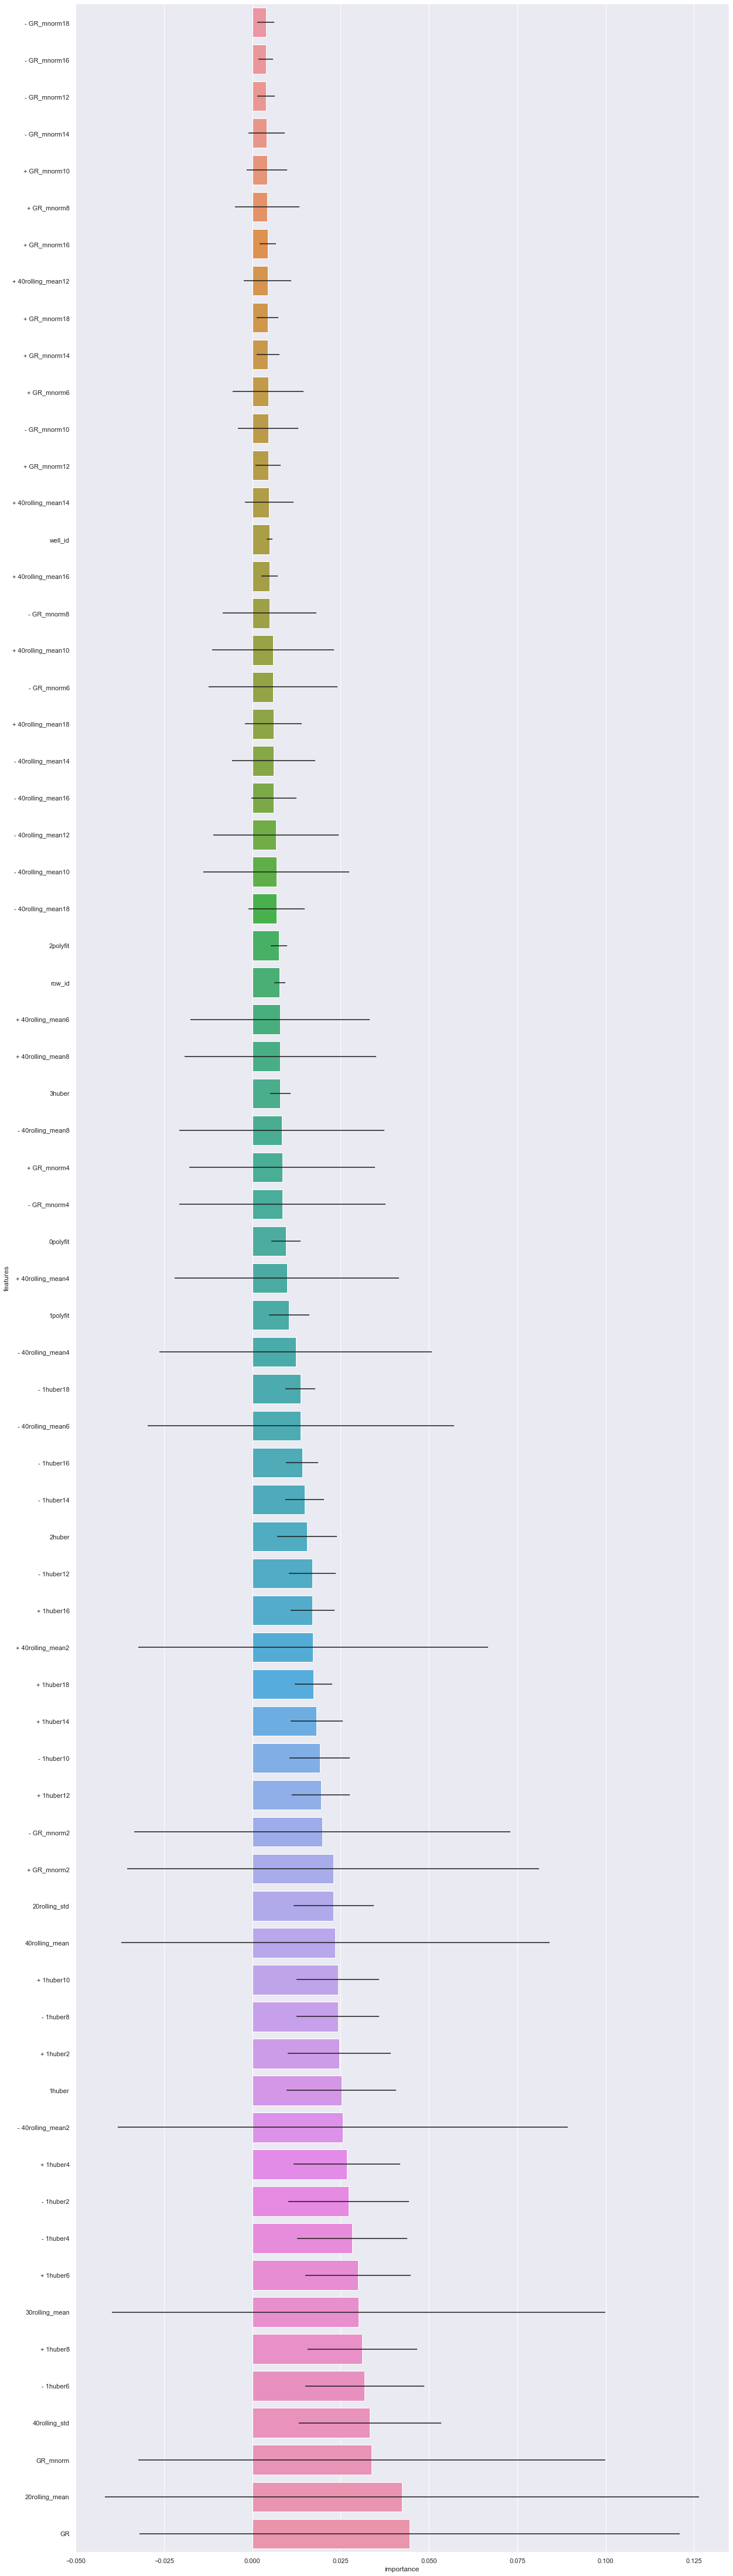

In [102]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,80)})
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
importance = model.feature_importances_
features = x_train.columns

feature_importance = pd.DataFrame()
feature_importance["importance"] = importance
feature_importance["std"] = std
feature_importance["features"] = features
feature_importance.sort_values("importance",ascending=True, inplace=True)
feature_importance.reset_index(drop = True , inplace = True)
sns.barplot(data =feature_importance , x ="importance", y ="features",xerr=feature_importance["std"])

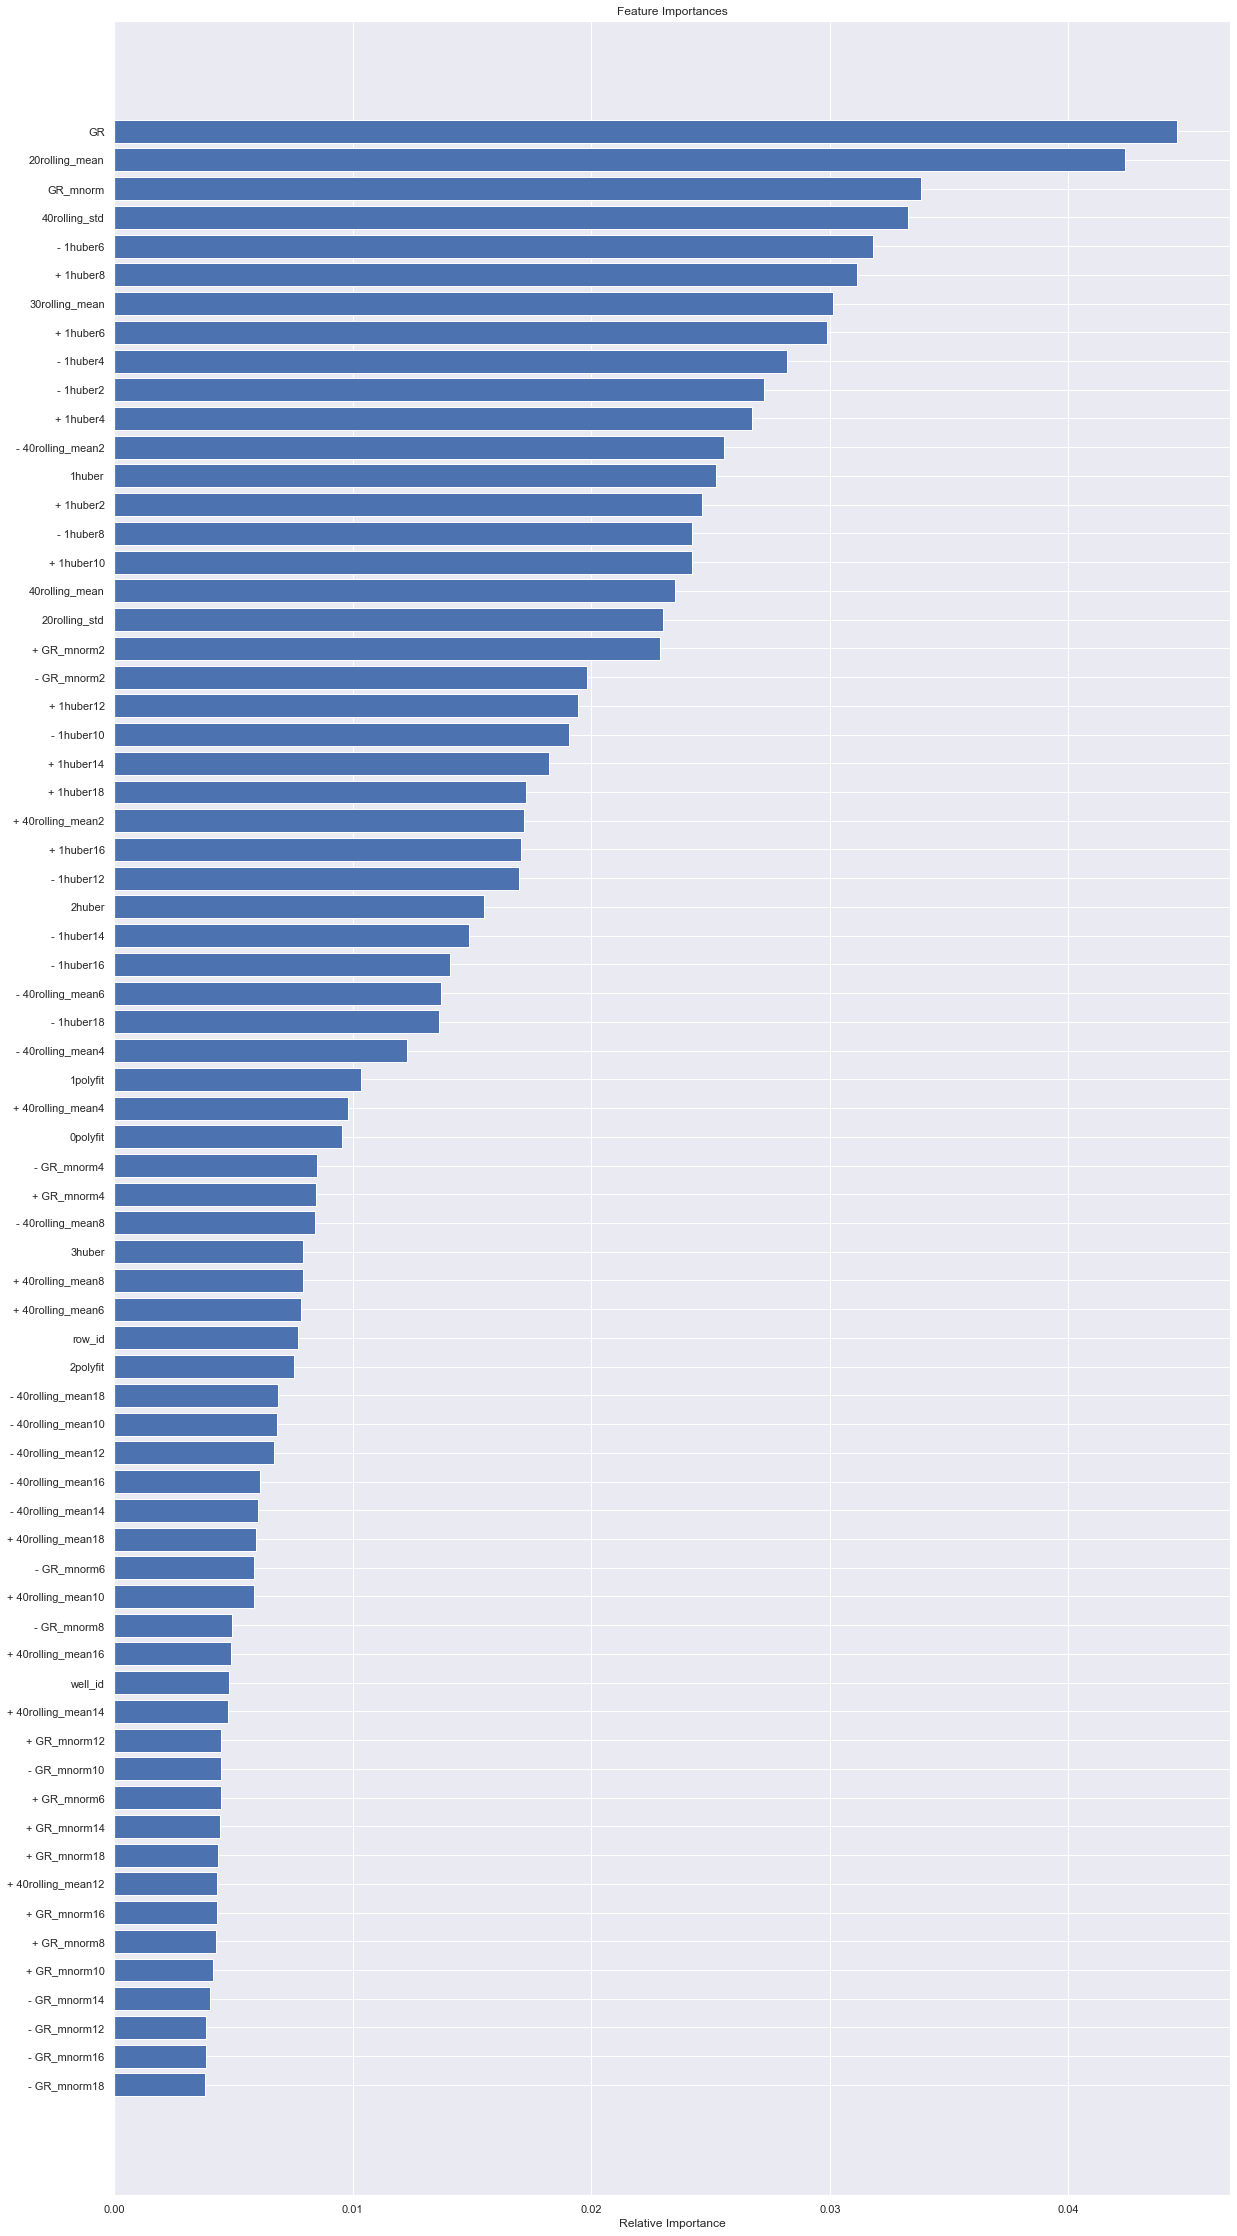

In [101]:
features = x_test.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
plt.title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Planteo de Random foresto optimizacion no utilizado

In [ ]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [ ]:
'''rf = RandomForestClassifier()
gs = GridSearchCV(rf,{ 'max_depth': np.arange(20,51,5),
                    'n_estimators':np.arange(400,1500,150),
                    'max_features':np.arange(0.39,0.91,0.05)}
                      ,verbose=2,n_jobs=-1, 
                        error_score='raise')

gs.fit(x_train,y_train.values.ravel())
gs.best_score_, gs.best_params_'''
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_estimator_